# Анализ временного ряда числа автомобильных аварий по дням на основе исключительно авторегрессии

$_{\text{Коротков Алексей, 2021г}}$

Поиск подходящего датасета занял некоторое время. 
Первоначальный датасет был взят с [сайта правительства Великобритании](https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data) по данным о количестве автомобильных аварий в стране по дням за 2005-2017 годы. 
Ввиду своего объема, пришлось разбить его на десять фрагментов, после чего функцией get_dummies() собрать сведения о числе аварий по дням

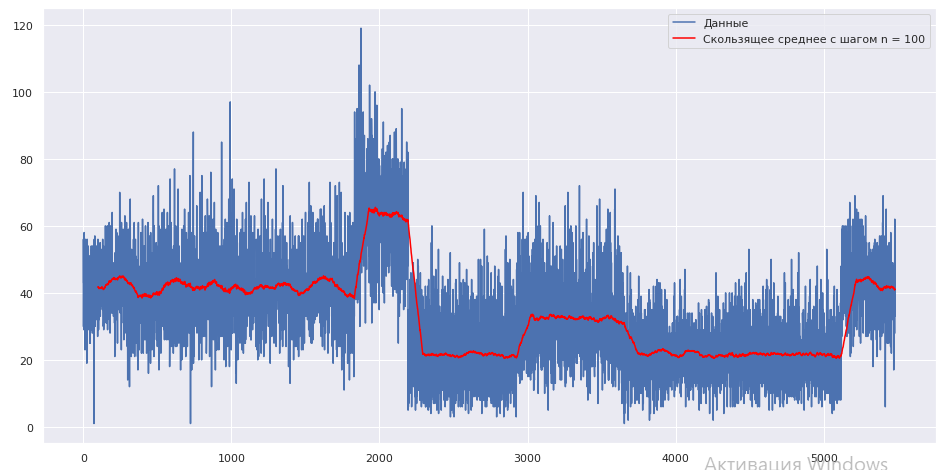

Данные по автомобильным авариям обладают годичным периодом. Однако большие датасеты не всегда равномерные, поэтому поиск грамотного датасета - немалая задача. Лучшее, что я разыскал - датасет с [Kaggle](https://www.kaggle.com/sadeghjalalian/road-accident-in-uk) с данными с 2014 по 2017 год включительно.

Загрузим необходимые библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
data = pd.read_csv('accident_UK_old.csv')
acc = data['Total_Accident']
dates = pd.to_datetime(data['Date'],dayfirst = True)

Посмотрим данные за один год:

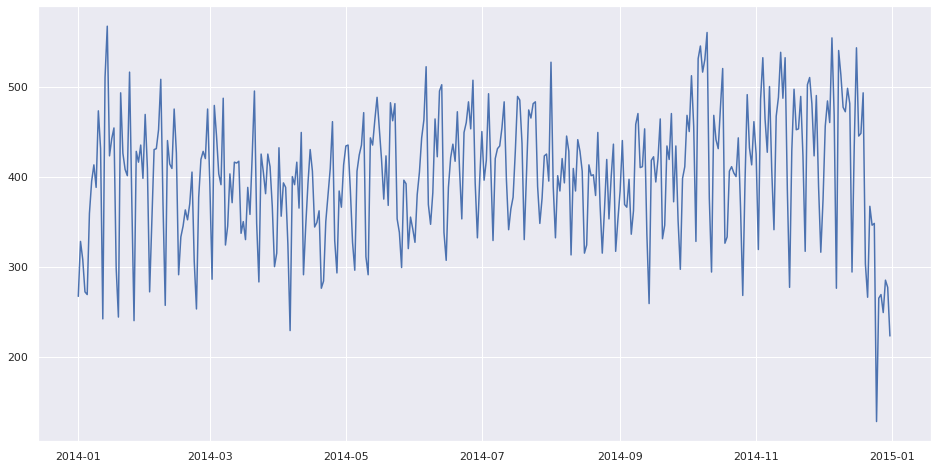

In [6]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(dates[:365],acc[:365])
plt.show()

Построим скользящее среднее для разных размеров рамок

In [23]:
def plot_rolling(n,year = True, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rolling_mean = acc.rolling(window=n).mean()
    plt.figure(figsize=(16,8))
    plt.grid(True)
    if year:
        plt.plot(dates[:365],acc[:365],label = 'Данные')
        plt.plot(dates[:365],rolling_mean[:365], label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    else:
        plt.plot(dates,acc,label = 'Данные')
        plt.plot(dates,rolling_mean, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(acc[n:], rolling_mean[n:])
        deviation = np.std(acc[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(dates,upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(dates,lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = []
            indexes = []
            for i in range(len(acc)):
                if acc[i]<lower_bond[i] or acc[i]>upper_bond[i]:
                    indexes.append(i)
                    anomalies.append(acc[i])
            plt.plot(dates[indexes],anomalies, "ro", markersize=10)
        
    plt.legend()
    plt.show()

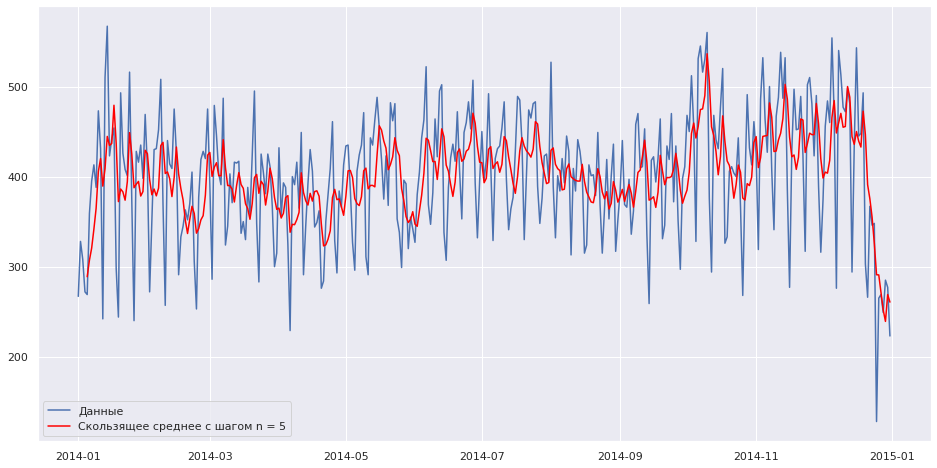

In [13]:
plot_rolling(5)

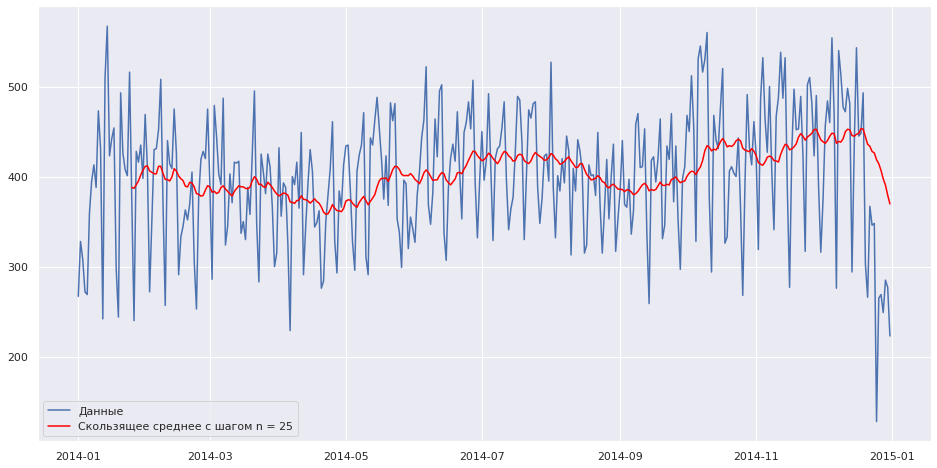

In [14]:
plot_rolling(25)

Посмотрим данные за все четыре года

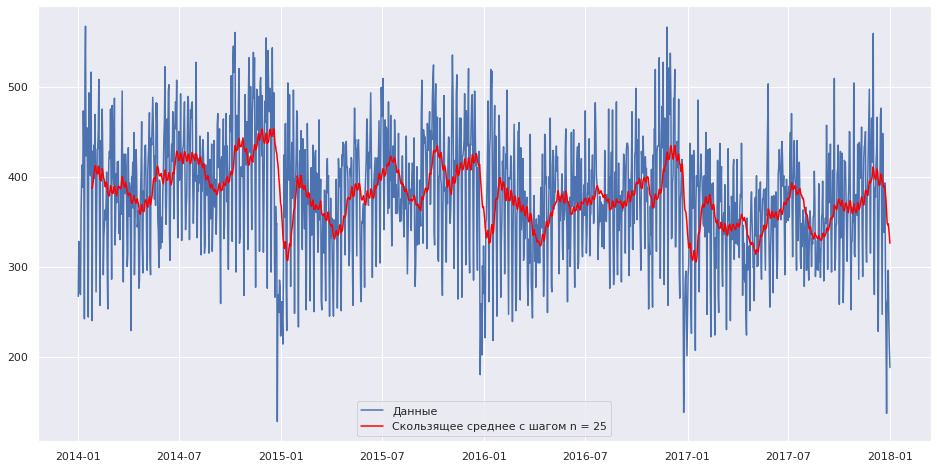

In [16]:
plot_rolling(25,False)

Расширим окно скользящего среднего до ста дней

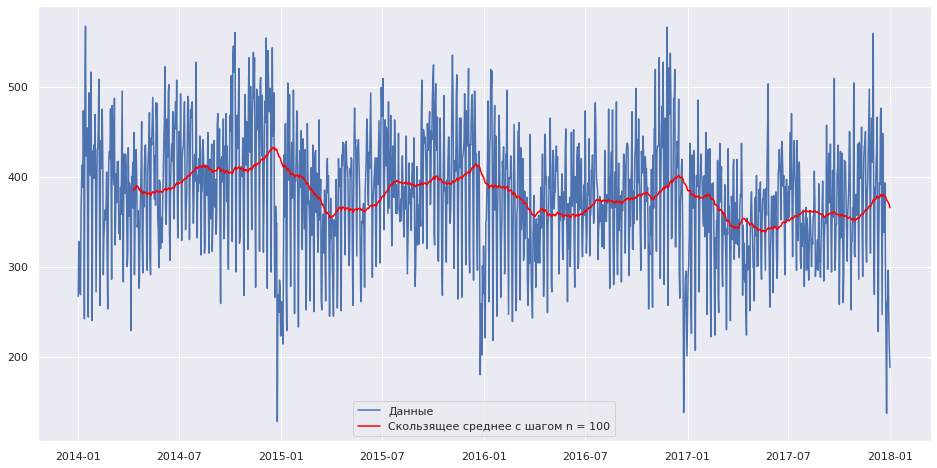

In [17]:
plot_rolling(100,False)

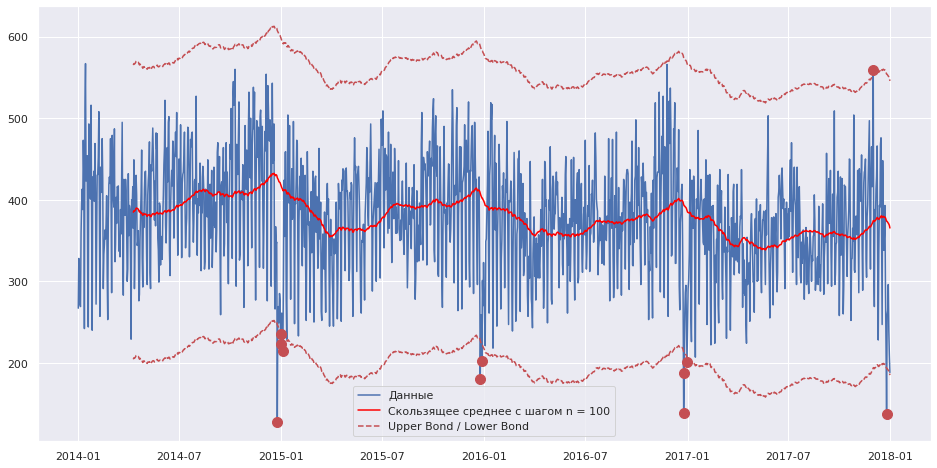

In [24]:
plot_rolling(100, False, plot_intervals=True, plot_anomalies=True)

Заметен ниспадающий тренд и периодичность

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [25]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [26]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    plt.figure(figsize=(16, 8))
    plt.plot(series.values, label = "Данные")
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

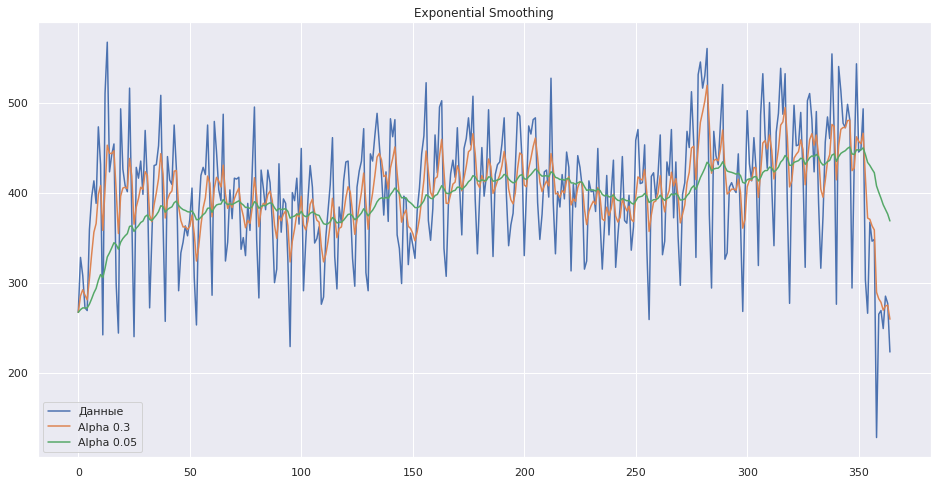

In [27]:
plotExponentialSmoothing(acc[:365], [0.3, 0.05])

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [28]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
       
    plt.figure(figsize=(20, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Данные")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

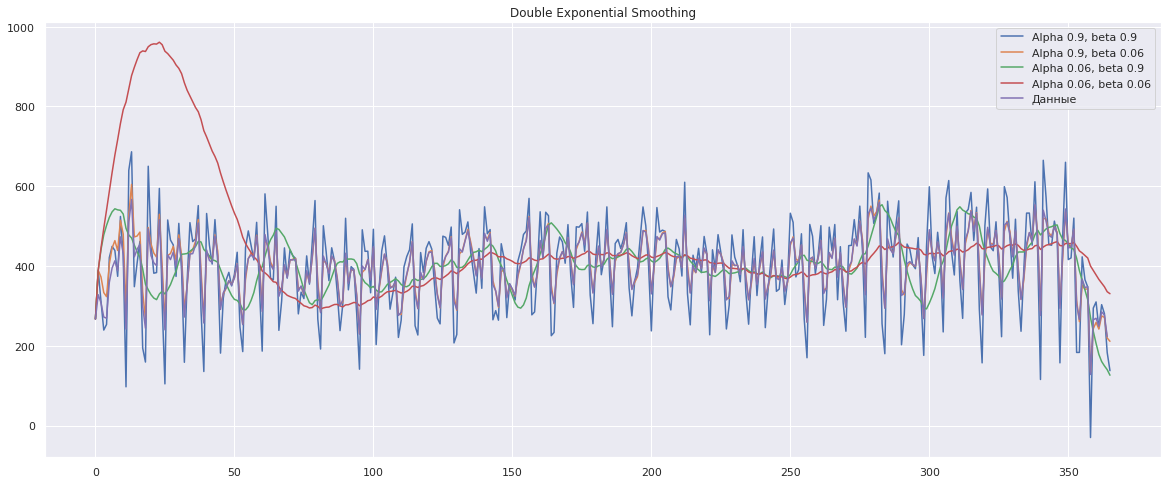

In [29]:
plotDoubleExponentialSmoothing(acc[:365], alphas=[0.9, 0.06], betas=[0.9, 0.06])

In [30]:
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже импортируем класс для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [31]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [32]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=365):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in [[acc[265:996],acc[996:]],[acc[:996],acc[996:]]]:

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [33]:
%%time
data = acc[:-100] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 365, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds =150, scaling_factor = 2)
model.triple_exponential_smoothing()

0.0175665894249864 0.004247560075279655 0.34334242014354976
CPU times: user 29.4 s, sys: 0 ns, total: 29.4 s
Wall time: 29.5 s


In [34]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False, years = False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    if years:
        a = model.result
        b = series.values
        for i in range(4):
            plt.figure(figsize=(20, 10))
            if i==3:
                plt.plot(a[3*365:], label = "Model")
            else:
                plt.plot(a[i*365:365*(i+1)], label = "Model")
            plt.plot(b[i*365:365*(i+1)], label = "Actual")
            error = mean_absolute_percentage_error(series.values[i*365:365*(i+1)], model.result[:len(series)][i*365:365*(i+1)])
            plt.title("Year "+str(i+1)+". Mean Absolute Percentage Error: {0:.2f}%".format(error))
            if plot_anomalies:
                c = model.UpperBond[i*365:365*(i+1)]
                d = model.LowerBond[i*365:365*(i+1)]
                anomalies_x = []
                anomalies_y = []
                for j in range(len(c)):
                    if b[i*365+j] > c[j] or b[i*365+j]<d[j]:
                        anomalies_x.append(j)
                        anomalies_y.append(b[i*365+j])
                plt.plot(anomalies_x, anomalies_y, "o", markersize=10, label = "Anomalies")
                    
            
            if i==3:
                plt.plot(model.UpperBond[i*365:], "r--", alpha=0.5, label = "Up/Low confidence")
                plt.plot(model.LowerBond[i*365:], "r--", alpha=0.5)
            else:
                plt.plot(model.UpperBond[i*365:365*(i+1)], "r--", alpha=0.5, label = "Up/Low confidence")
                plt.plot(model.LowerBond[i*365:365*(i+1)], "r--", alpha=0.5)
            plt.fill_between(x=range(0,len(model.result[i*365:365*(i+1)])), y1=model.UpperBond[i*365:365*(i+1)], 
                             y2=model.LowerBond[i*365:365*(i+1)], alpha=0.2, color = "grey") 
            plt.grid(True)
            plt.axis('tight')
            plt.legend(loc="best", fontsize=13);
    else:
        plt.figure(figsize=(20, 10))
        plt.plot(model.result, label = "Model")
        plt.plot(series.values, label = "Actual")
        error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
        plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(series))
            anomalies[series.values<model.LowerBond[:len(series)]] = \
                series.values[series.values<model.LowerBond[:len(series)]]
            anomalies[series.values>model.UpperBond[:len(series)]] = \
                series.values[series.values>model.UpperBond[:len(series)]]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    

    if years:
        plt.vlines(365, ymin=min(model.LowerBond[:-365]), ymax=max(model.UpperBond[:-365]), linestyles='dashed')
        plt.axvspan(265, 365+50, alpha=0.3, color='lightgrey')
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc="best", fontsize=13);
    else:
        plt.vlines(len(series), ymin=100, ymax=600, linestyles='dashed')
        plt.axvspan(len(series)-100, len(model.result), alpha=0.3, color='lightgrey')
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc="best", fontsize=13);

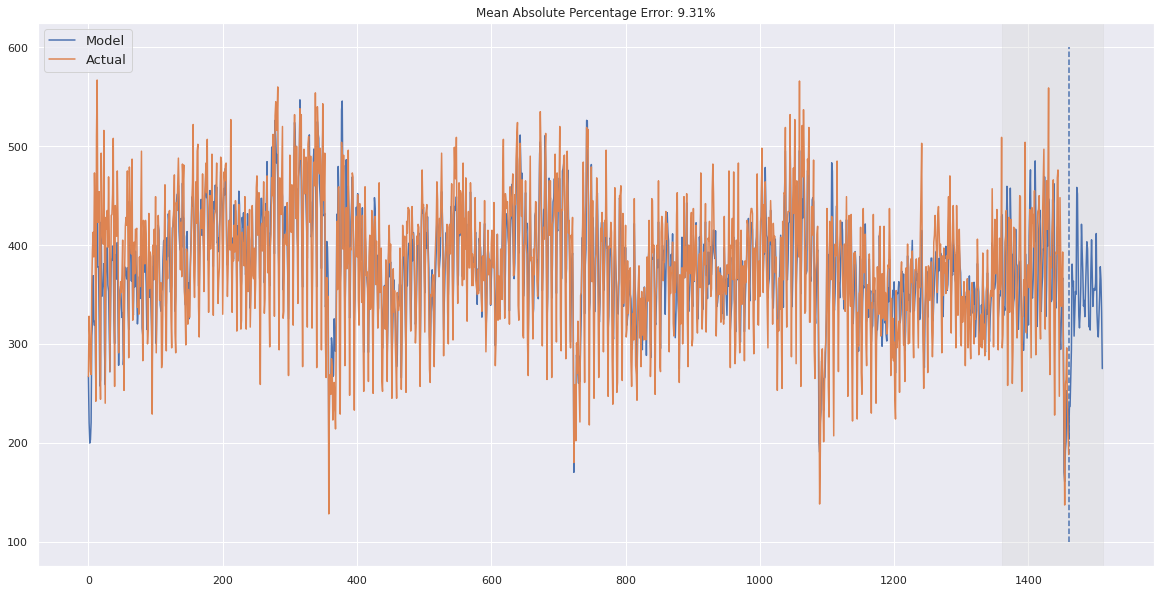

In [35]:
plotHoltWinters(acc)

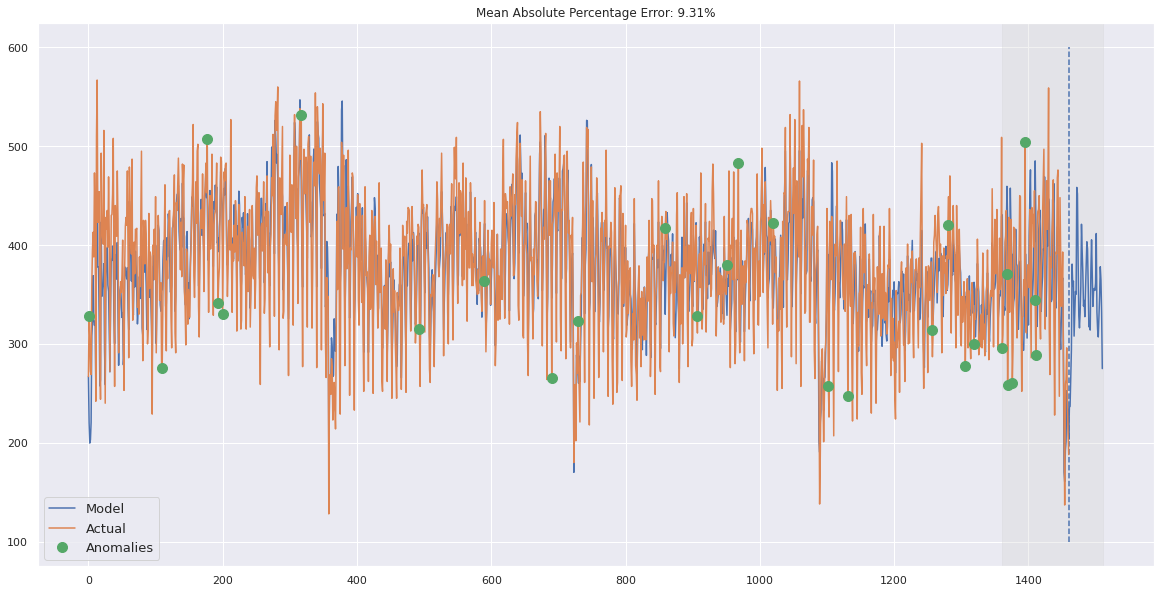

In [36]:
plotHoltWinters(acc,plot_anomalies = True)

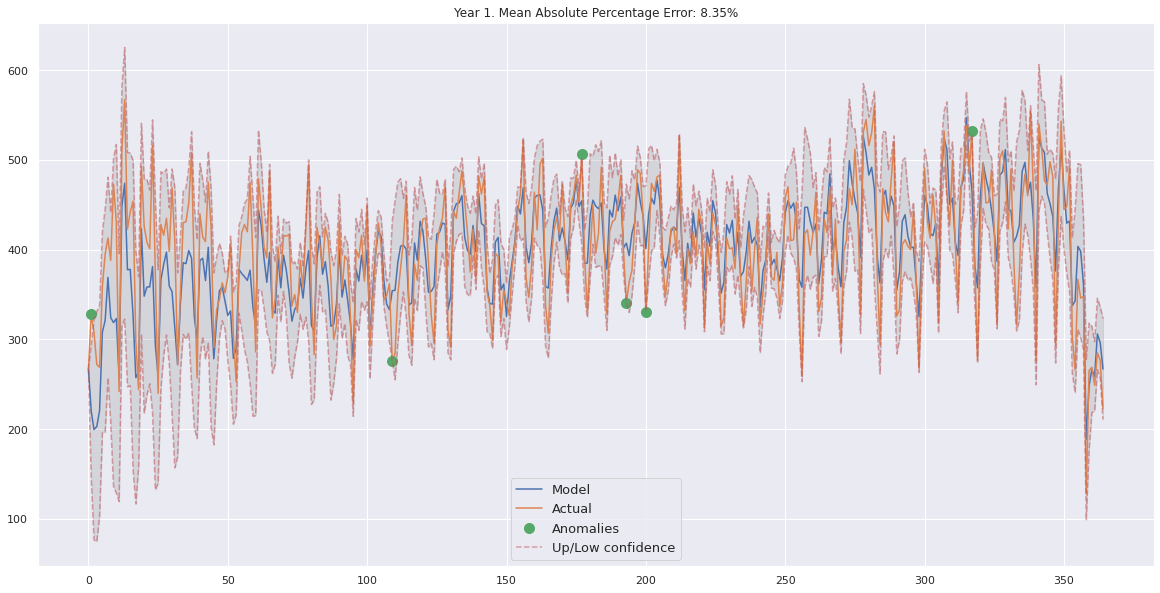

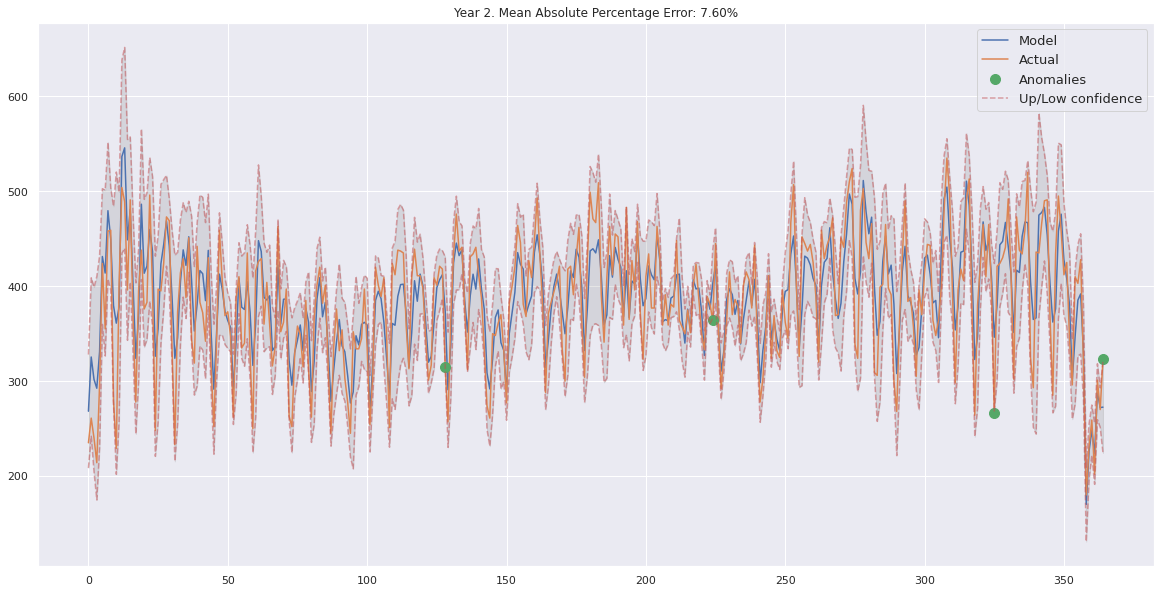

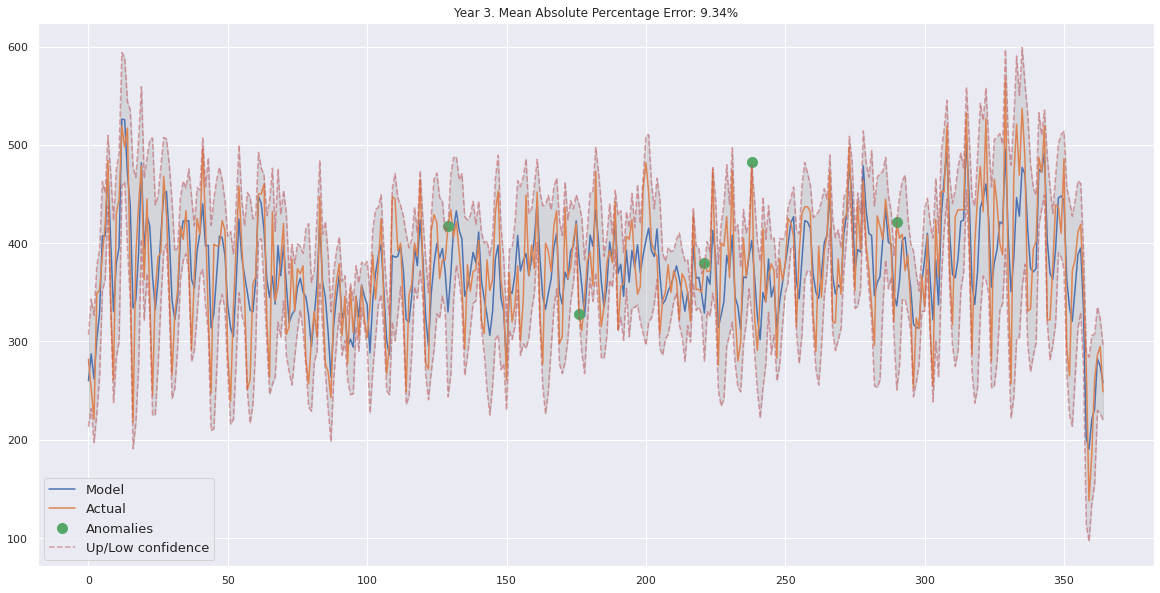

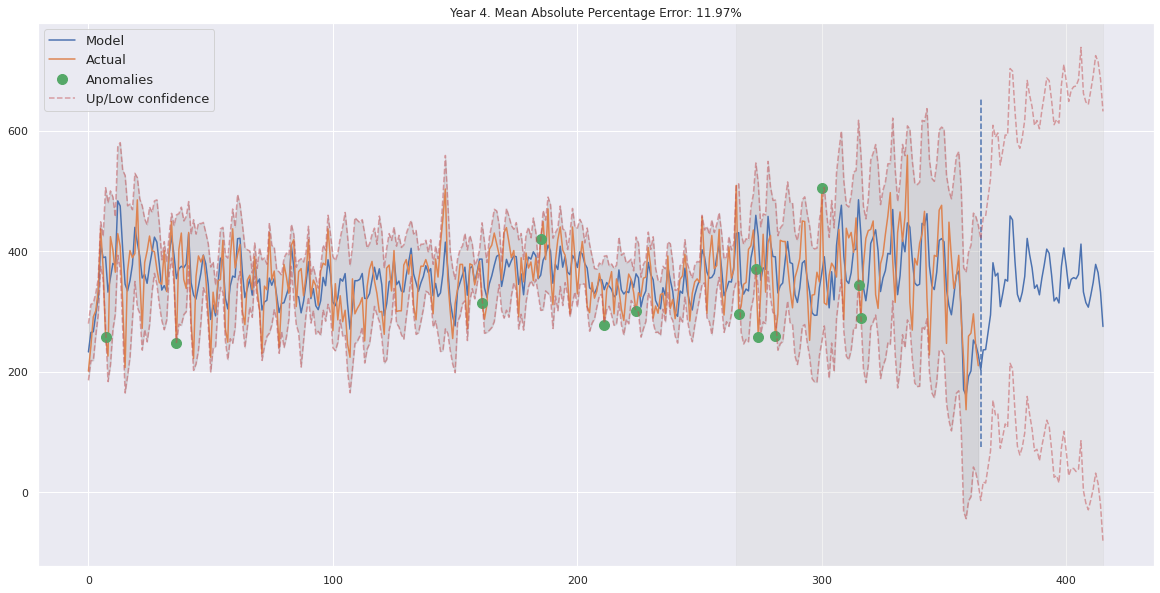

In [37]:
plotHoltWinters(acc,years = True,plot_anomalies = True)

Повторим все процедуры с данными по неделям, таким образом мы сократим число точек в семь раз и обретём возможность запустить SARIMA.

In [39]:
weekdata = pd.DataFrame({'amount': [sum(acc.values[7*i:7*(i+1)]) for i in range(len(acc.values)//7)]})

In [40]:
def plot_rolling(n,year = True, plot_intervals=False, scale=1.96, plot_anomalies=False,acc=weekdata):
    rolling_mean = acc.rolling(window=n).mean()
    plt.figure(figsize=(16,8))
    plt.grid(True)
    if year:
        plt.plot(acc[:365],label = 'Данные')
        plt.plot(rolling_mean[:365], label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    else:
        plt.plot(acc,label = 'Данные')
        plt.plot(rolling_mean, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(acc[n:], rolling_mean[n:])
        deviation = np.std(acc[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = []
            indexes = []
            for i in range(len(acc)):
                if acc[i]<lower_bond[i] or acc[i]>upper_bond[i]:
                    indexes.append(i)
                    anomalies.append(acc[i])
            plt.plot(indexes,anomalies, "ro", markersize=10)
        
    plt.legend()
    plt.show()

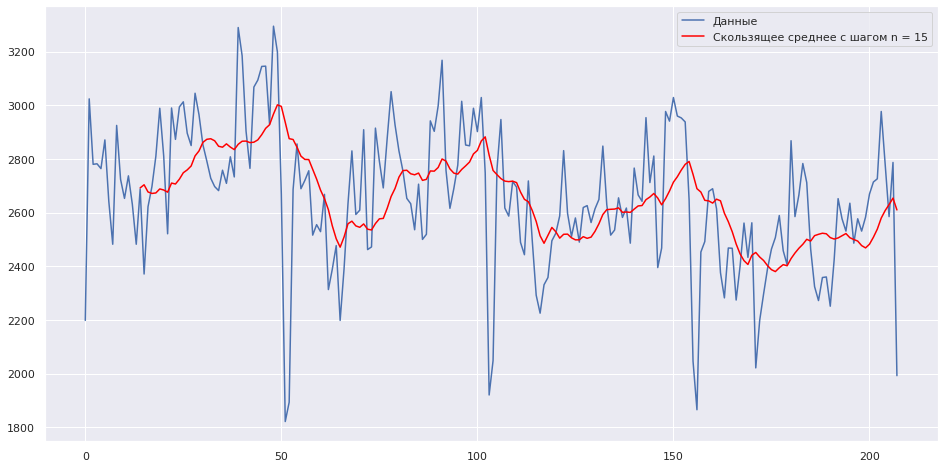

In [41]:
plot_rolling(15,year=False)

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

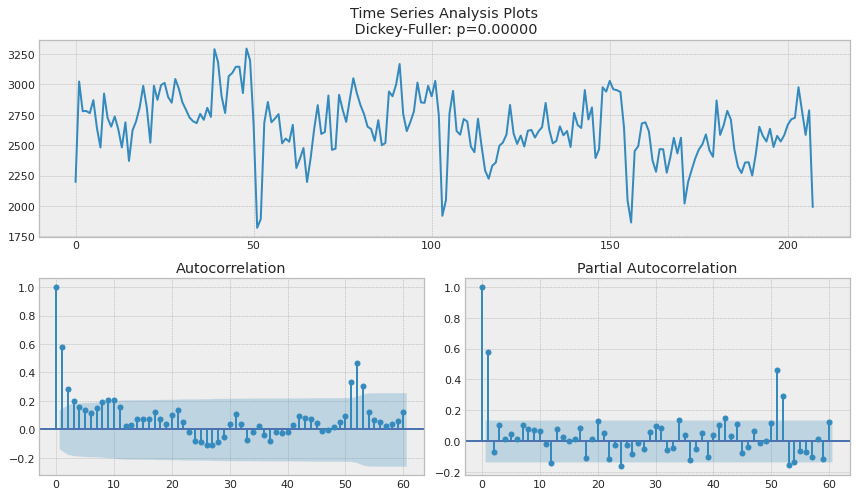

In [44]:
amount0 = weekdata.amount
tsplot(amount0,60)

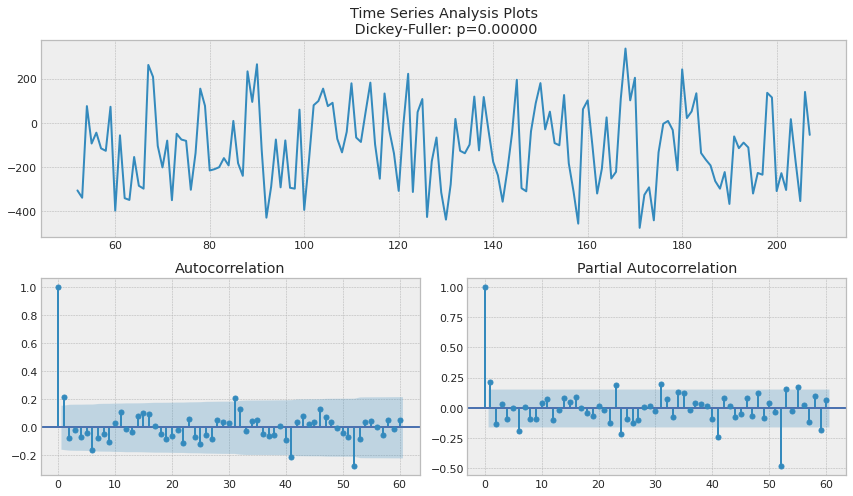

In [45]:
amount1 = amount0 - amount0.shift(52)
tsplot(amount1[52:],60)

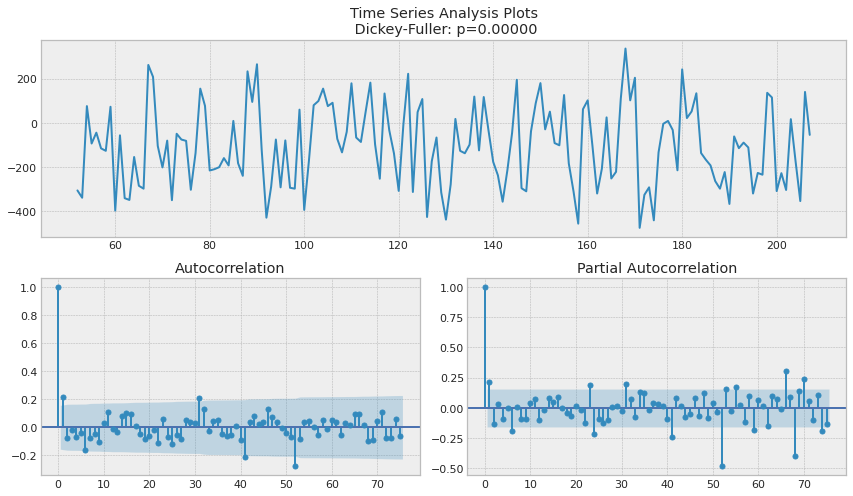

In [49]:
amount2 = amount1 - amount1.shift(1)
tsplot(amount1[52:],75)

In [50]:
#p = 1
#q = 1
#d = 0
#s = 52
#P = 1
#Q = 1
#D = 1

In [51]:
# setting initial values and some bounds for them
ps = range(1, 4)
d=0 
qs = range(1, 4)
Ps = range(1, 3)
D=1 
Qs = range(1, 3)
s = 52

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [52]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(weekdata.amount, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [53]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 6d 10h 4min 12s, sys: 8d 6h 27min 12s, total: 14d 16h 31min 25s
Wall time: 3h 17s


In [54]:
result_table.head(7)

,parameters,aic
0,"(2, 2, 1, 1)",2051.736233
1,"(1, 3, 1, 1)",2052.441922
2,"(1, 2, 1, 1)",2052.999572
3,"(2, 2, 2, 1)",2053.711358
4,"(2, 2, 1, 2)",2053.780571
5,"(3, 2, 1, 1)",2054.015073
6,"(1, 3, 1, 2)",2054.326997


In [55]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(weekdata.amount, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               amount   No. Observations:                  208
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 52)   Log Likelihood               -1018.868
Date:                              Fri, 26 Mar 2021   AIC                           2051.736
Time:                                      16:10:51   BIC                           2073.085
Sample:                                           0   HQIC                          2060.407
                                              - 208                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6121      0.174      3.511      0.000       0.270       0.954
ar.L2          0.36

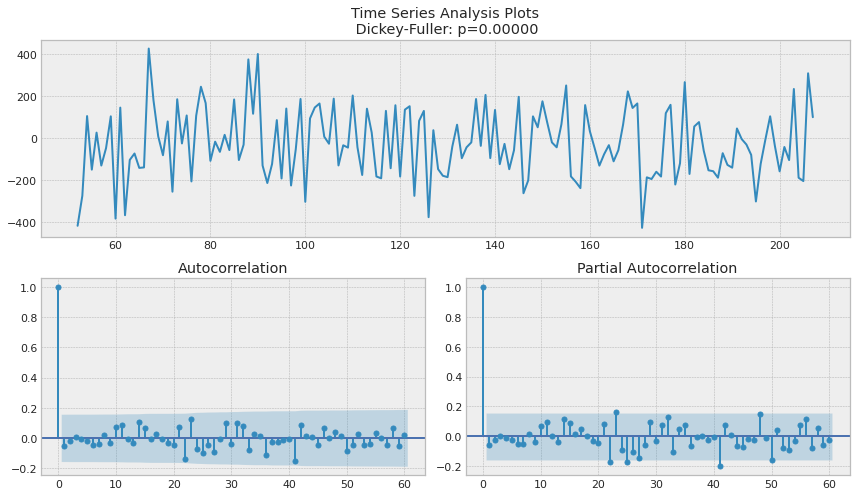

In [58]:
tsplot(best_model.resid[52:], lags=60)

In [59]:
def plotSARIMA(series, model, n_steps, s=52, d=4, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # forecasting on n_steps forward 
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

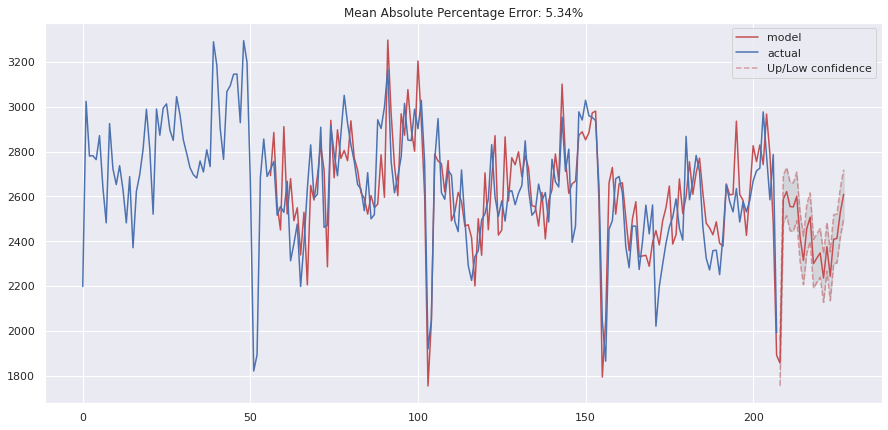

In [67]:
plotSARIMA(weekdata, best_model, 20, alpha=0.5)

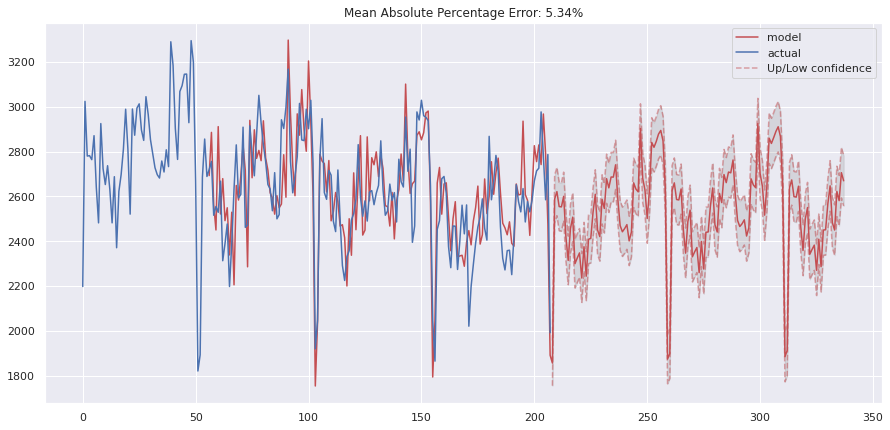

In [68]:
plotSARIMA(weekdata, best_model, 130, alpha=0.5)